<a href="https://colab.research.google.com/github/L4ncelot1024/Learn_Deep_Learning_Le_Wagon/blob/main/Day3/03_Demand_Forecasting_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand Forecasting with Deep Learning

Here we have access to historical transactions for a list of items in different store location on a daily basis.
Our task will be to predict the demand for an item in a store within a 90 days interval of time.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install chart_studio
import chart_studio.plotly.plotly as py
#import chart_studio.plotly.graph_objs as go
#from chart_studio.plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
#init_notebook_mode(connected=True)

     |████████████████████████████████| 71kB 3.6MB/s 


In [ ]:
# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

## Downloading the data

For this notebook, we will use data available on the github repository so first download the dataset from the repository [here](https://github.com/lewagon/dl-week-challenges/tree/master/04-Advanced-RNN-for-Time-Series/03-Demand-Forecasting-with-Deep-Learning) (you can access it if you already git clone the repository, make sure your local version is up-to-date, otherwise you simply need to run a `git pull`) and then upload it with the following cell to your Drive:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving demand-forecasting-kernels-only.zip to demand-forecasting-kernels-only.zip
User uploaded file "demand-forecasting-kernels-only.zip" with length 3454726 bytes


In [ ]:
# Unzip the data
!unzip demand-forecasting-kernels-only.zip

Archive:  demand-forecasting-kernels-only.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# Here we read the training and test data.
train = pd.read_csv('./train.csv', parse_dates=['date'])
test = pd.read_csv('./test.csv', parse_dates=['date'])

## Statistics the data

First, let's look at the dataset.

In [ ]:
print(train.shape)
train.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train.describe()


,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
# Let's check the time range of the two period, train and test.

# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

print('Min date from test set: %s' % test['date'].min().date())
print('Max date from test set: %s' % test['date'].max().date())

test_interval = (test['date'].max().date() - train['date'].max().date()).days
print('Number of days to predict', test_interval, ' days')
```
</details>



## Preparing the data

Our task is to predict the sales for each item in each store in a 90 days period, which follows the training data we have. 

Our approach is to treat our data as time series of sales accross store and items on a daily basis.

Then we can try different approaches, we'll focus the simplest one:

- Predict the next time step based on a single one and repeat this (*one-to-one*);


To satisfy this approach, we first need to prepare the data following these steps:
- flattenning the data in our time series format (one day per row and sales across items and stores as columns);
- encoding in each row the dates so our model can take into account the seasonality of the data;

### Flattening the data

In [ ]:
# First let's extract for each tuple (item, store) the Serie of sales with the 
# date as index
# NB: this would be our time serie in the case of only 1 tuple (item, store)

# YOUR CODE HERE
def get_sales_for_item_store(df, item, store):
  ...
  pass

# Here we apply this function on store 1 and item 1 as a sanity check
get_sales_for_item_store(train, 1, 1)  

<details>
  <summary>Hint</summary>
    
```markdown
Here you just want to extract some rows of your input dataframe, using a condition on the item and on the store and to return the time columns as index and the sales as column.
```
    
</details>
​
<details>
  <summary>View solution</summary>
    
```python
def get_sales_for_item_store(df, item, store):
  tmp_df = df[(df['item'] == item) & (df['store'] == store)]
  tmp_df = tmp_df.set_index('date')
  return tmp_df.drop(['store', 'item'], axis=1)

```
</details>



In [ ]:
# Let's build our flattenned dataframe with this function. We need to loop
# over all the possible tuples, create the series, update the column name
# sales -> item_{i}_store_{s}_sales (to be able to differentiate them) and 
# concatenate them into a single table
# NB: since we indexed by dates our serie, we can simply join them. This will
# prevent misalignement issue in case some dates are missing for some (item, store)
from itertools import product

def col_name(i, s):
  return f'item_{i}_store_{s}_sales'

def flatten_df(df):
  # YOUR CODE HERE
  flattened_df = ...
  return flattened_df

train_flattened_df = flatten_df(train)

<details>
  <summary>View solution</summary>
    
```python
from itertools import product

def col_name(i, s):
  return f'item_{i}_store_{s}_sales'

def flatten_df(df):
  num_items = df.item.nunique()
  num_stores = df.store.nunique()
  flattened_df = pd.DataFrame()
  for item, store in product(range(1, num_items + 1), range(1, num_stores + 1)):
    if len(flattened_df) == 0:
      flattened_df = get_sales_for_item_store(df, item, store).rename(columns={'sales': col_name(item, store)})
    else:
      tmp_df = get_sales_for_item_store(df, item, store).rename(columns={'sales': col_name(item, store)})
      flattened_df = flattened_df.join(tmp_df, how='outer')
  return flattened_df

train_flattened_df = flatten_df(train)
```
</details>





In [ ]:
print(train_flattened_df.shape)
train_flattened_df.head()

(1826, 500)


,item_1_store_1_sales,item_1_store_2_sales,item_1_store_3_sales,item_1_store_4_sales,item_1_store_5_sales,item_1_store_6_sales,item_1_store_7_sales,item_1_store_8_sales,item_1_store_9_sales,item_1_store_10_sales,item_2_store_1_sales,item_2_store_2_sales,item_2_store_3_sales,item_2_store_4_sales,item_2_store_5_sales,item_2_store_6_sales,item_2_store_7_sales,item_2_store_8_sales,item_2_store_9_sales,item_2_store_10_sales,item_3_store_1_sales,item_3_store_2_sales,item_3_store_3_sales,item_3_store_4_sales,item_3_store_5_sales,item_3_store_6_sales,item_3_store_7_sales,item_3_store_8_sales,item_3_store_9_sales,item_3_store_10_sales,item_4_store_1_sales,item_4_store_2_sales,item_4_store_3_sales,item_4_store_4_sales,item_4_store_5_sales,item_4_store_6_sales,item_4_store_7_sales,item_4_store_8_sales,item_4_store_9_sales,item_4_store_10_sales,...,item_47_store_1_sales,item_47_store_2_sales,item_47_store_3_sales,item_47_store_4_sales,item_47_store_5_sales,item_47_store_6_sales,item_47_store_7_sales,item_47_store_8_sales,item_47_store_9_sales,item_47_store_10_sales,item_48_store_1_sales,item_48_store_2_sales,item_48_store_3_sales,item_48_store_4_sales,item_48_store_5_sales,item_48_store_6_sales,item_48_store_7_sales,item_48_store_8_sales,item_48_store_9_sales,item_48_store_10_sales,item_49_store_1_sales,item_49_store_2_sales,item_49_store_3_sales,item_49_store_4_sales,item_49_store_5_sales,item_49_store_6_sales,item_49_store_7_sales,item_49_store_8_sales,item_49_store_9_sales,item_49_store_10_sales,item_50_store_1_sales,item_50_store_2_sales,item_50_store_3_sales,item_50_store_4_sales,item_50_store_5_sales,item_50_store_6_sales,item_50_store_7_sales,item_50_store_8_sales,item_50_store_9_sales,item_50_store_10_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,12,19,10,11,20,7,16,11,14,33,41,43,30,26,27,21,39,31,36,15,19,26,17,14,13,9,21,20,18,10,21,9,13,4,7,6,13,10,9,...,17,12,10,23,9,5,4,19,6,11,21,45,28,34,21,21,27,27,28,25,18,29,21,12,9,11,19,12,11,17,30,43,45,38,19,20,21,45,36,33
2013-01-02,11,16,8,12,9,6,4,10,9,14,43,33,27,28,22,18,23,25,26,34,30,32,16,23,16,14,11,21,22,28,11,14,15,16,5,7,8,10,15,9,...,15,13,12,11,10,10,4,16,14,13,26,37,32,26,22,20,21,35,38,24,10,25,14,18,13,10,13,27,16,13,32,57,47,35,25,23,30,54,44,37
2013-01-03,14,16,10,8,12,11,8,12,20,16,23,46,38,37,26,20,13,34,33,34,14,26,17,27,15,13,14,21,20,26,8,12,9,12,8,17,9,16,7,14,...,5,5,13,11,14,10,4,8,18,16,25,45,40,33,24,27,11,22,24,29,17,30,22,22,16,16,9,16,20,19,25,45,39,32,28,38,20,54,29,46
2013-01-04,13,20,15,15,8,7,7,21,22,17,18,50,35,44,23,24,34,39,42,50,10,34,25,27,15,17,15,19,25,31,19,17,16,19,7,10,2,13,19,16,...,13,19,5,18,10,11,9,17,15,11,26,32,39,26,34,21,17,32,30,39,22,20,26,17,12,18,9,18,19,23,32,45,48,36,27,33,27,52,43,51
2013-01-05,10,16,22,19,13,12,8,15,22,12,34,44,47,36,22,32,25,45,50,42,23,25,34,19,10,21,14,24,25,22,12,14,16,13,7,14,15,18,16,19,...,12,18,14,18,7,9,8,18,13,16,28,53,47,33,24,24,28,40,33,34,15,20,22,19,19,13,12,21,16,22,35,55,46,47,31,33,18,48,53,41


### Encoding the date

We want to add in our time series the information of the date, both the day of the week and the month, to encode the seasonality.

Add columns to encode the weekday and the month. To do so, we suggest to 
use one-hot-encoding to encode the two, you can use the pandas function 
`get_dummies` described [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). You can directly access the weekday and the month by calling the attribute `weekday` and `month` on an object of date datatype.

In [ ]:
# First convert the index of your data into a date object so you can access 
# the two attributes
train_flattened_df.index = pd.to_datetime(train_flattened_df.index)

In [ ]:
# Adding both the weekday and the mongh, use the argument `prefix` to be able to
# differentiate between the weekday and the month
def encode_dates(df):
  # YOUR CODE HERE
  pass


In [ ]:
# This is to test the code from above, you should see a train dataframe with dimension (1826, 519)
train_encoded_dates = encode_dates(train_flattened_df)
print(train_encoded_dates.shape)
train_encoded_dates.head()

(1826, 519)


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1_store_1_sales,item_1_store_2_sales,item_1_store_3_sales,item_1_store_4_sales,item_1_store_5_sales,item_1_store_6_sales,item_1_store_7_sales,item_1_store_8_sales,item_1_store_9_sales,item_1_store_10_sales,item_2_store_1_sales,item_2_store_2_sales,item_2_store_3_sales,item_2_store_4_sales,item_2_store_5_sales,item_2_store_6_sales,item_2_store_7_sales,item_2_store_8_sales,item_2_store_9_sales,item_2_store_10_sales,item_3_store_1_sales,...,item_47_store_1_sales,item_47_store_2_sales,item_47_store_3_sales,item_47_store_4_sales,item_47_store_5_sales,item_47_store_6_sales,item_47_store_7_sales,item_47_store_8_sales,item_47_store_9_sales,item_47_store_10_sales,item_48_store_1_sales,item_48_store_2_sales,item_48_store_3_sales,item_48_store_4_sales,item_48_store_5_sales,item_48_store_6_sales,item_48_store_7_sales,item_48_store_8_sales,item_48_store_9_sales,item_48_store_10_sales,item_49_store_1_sales,item_49_store_2_sales,item_49_store_3_sales,item_49_store_4_sales,item_49_store_5_sales,item_49_store_6_sales,item_49_store_7_sales,item_49_store_8_sales,item_49_store_9_sales,item_49_store_10_sales,item_50_store_1_sales,item_50_store_2_sales,item_50_store_3_sales,item_50_store_4_sales,item_50_store_5_sales,item_50_store_6_sales,item_50_store_7_sales,item_50_store_8_sales,item_50_store_9_sales,item_50_store_10_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13,12,19,10,11,20,7,16,11,14,33,41,43,30,26,27,21,39,31,36,15,...,17,12,10,23,9,5,4,19,6,11,21,45,28,34,21,21,27,27,28,25,18,29,21,12,9,11,19,12,11,17,30,43,45,38,19,20,21,45,36,33
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,11,16,8,12,9,6,4,10,9,14,43,33,27,28,22,18,23,25,26,34,30,...,15,13,12,11,10,10,4,16,14,13,26,37,32,26,22,20,21,35,38,24,10,25,14,18,13,10,13,27,16,13,32,57,47,35,25,23,30,54,44,37
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,14,16,10,8,12,11,8,12,20,16,23,46,38,37,26,20,13,34,33,34,14,...,5,5,13,11,14,10,4,8,18,16,25,45,40,33,24,27,11,22,24,29,17,30,22,22,16,16,9,16,20,19,25,45,39,32,28,38,20,54,29,46
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13,20,15,15,8,7,7,21,22,17,18,50,35,44,23,24,34,39,42,50,10,...,13,19,5,18,10,11,9,17,15,11,26,32,39,26,34,21,17,32,30,39,22,20,26,17,12,18,9,18,19,23,32,45,48,36,27,33,27,52,43,51
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,10,16,22,19,13,12,8,15,22,12,34,44,47,36,22,32,25,45,50,42,23,...,12,18,14,18,7,9,8,18,13,16,28,53,47,33,24,24,28,40,33,34,15,20,22,19,19,13,12,21,16,22,35,55,46,47,31,33,18,48,53,41



<details>
  <summary>View solution</summary>
    
```python
# Adding both the weekday and the mongh, use the argument `prefix` to be able to
# differentiate between the weekday and the month
def encode_dates(df):
  weekday_df = pd.get_dummies(df.index.weekday, prefix='weekday')
  weekday_df.index = df.index

  month_df = pd.get_dummies(df.index.month, prefix='month')
  month_df.index =  df.index

  return pd.concat([weekday_df, month_df, df], axis=1)
```
</details>



### Train / Validation split

In [ ]:
print(train_encoded_dates.index.min())
print(train_encoded_dates.index.max())
# Let's take year 2017 as validation data so we can train our model 
# on 2013->2016 and evaluate it on the first quarter of 2017 

2013-01-01 00:00:00
2017-12-31 00:00:00


In [ ]:
cutoff_date = pd.to_datetime('2017-01-01')
train_data = train_encoded_dates[train_encoded_dates.index < cutoff_date]
validation_data = train_encoded_dates[train_encoded_dates.index >= cutoff_date]

In [ ]:
# Sanity check
print('Min date from train set: %s' % train_data.index.min().date())
print('Max date from train set: %s' % train_data.index.max().date())

print('Min date from validation set: %s' % validation_data.index.min().date())
print('Max date from validation set: %s' % validation_data.index.max().date())

Min date from train set: 2013-01-01
Max date from train set: 2016-12-31
Min date from validation set: 2017-01-01
Max date from validation set: 2017-12-31


### Feature scaling

To avoid weighting differently sales of (item, store) which have different ranges we pre-process the time series with a feature scaler. We suggest to use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaler which is quite simple to use.
NB: we just want to scale the sales columns since the date one are binary it's not necessary.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define your scaler
scaler = ...
# Columns you want to scale
cols_to_scale = ...

# Train the scaler and apply it on the data (on the train and on the validation)
train_data_scaled = ...
validation_data_scaled = ...

<details>
  <summary>View solution</summary>
    
```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in train_data.columns if 'sales' in col]

# Training (and applying) the scaler on the train data
train_data_scaled = train_data.copy()
scaled_cols = scaler.fit_transform(train_data_scaled[cols_to_scale])
train_data_scaled[cols_to_scale] = scaled_cols

validation_data_scaled = validation_data.copy()
validation_data_scaled[cols_to_scale] = scaler.transform(validation_data[cols_to_scale])
```
</details>



## Model

### Architecture

Now it's the time to define the architecture, keep it simple first with a recurrent unit and a dense one, don't forget to compile it with a well chosen loss !

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

def build_simple_LSTM(seq_length, nb_features, n_unit, dropout=0.2):
  # YOUR CODE HERE
  return model



<details>
  <summary>View solution</summary>
    
```python
def build_simple_LSTM(seq_length, nb_features, n_unit, dropout=0.2):
  model = Sequential()

  model.add(LSTM(
          input_shape=(seq_length, nb_features),
          units=n_unit,
          return_sequences=False))
  model.add(Dropout(dropout))

  model.add(Dense(units=n_unit))
  model.compile(loss='mean_absolute_error', optimizer='adam')

  return model
```
</details>



### Formatting the data

In [ ]:
train_data_scaled.shape

(1461, 519)

In [ ]:
# Here we build the y data to contain 1 time step, so for a seq_length = 1.
# We just need to shift the data, the last time step of X has to be removed since
# we don't have a label for it (its next time step is in the validation)
X_train = train_data_scaled[:-1]
y_train = train_data_scaled[cols_to_scale][1:]

X_val = validation_data_scaled[:-1]
y_val = validation_data_scaled[cols_to_scale][1:]


In [ ]:
# The model expects data of size 
seq_length = 1
nb_features = X_train.shape[1]
nb_out = y_train.shape[1]

X_train_vals = X_train.values.reshape((len(X_train), seq_length, nb_features))
y_train_vals = y_train.values
print(X_train_vals.shape)
print(y_train_vals.shape)

X_valid_vals = X_val.values.reshape((len(X_val), seq_length, nb_features))
y_valid_vals = y_val.values
print(X_valid_vals.shape)
print(y_valid_vals.shape)

(1460, 1, 519)
(1460, 500)
(364, 1, 519)
(364, 500)


### Training

Build and fit the model on the data you prepared, feed it with the validation data to have the mean absolute error (mae) computed on the validation data in the history.

In [ ]:
# We suggest to use these values at first (since it uses reasonable ressources)
epochs=60
batch_size=30

# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
simple_model = build_simple_LSTM(1, nb_features, 64)

history = simple_model.fit(
    X_train_vals, 
    y_train_vals, 
    epochs=60, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid_vals),
    verbose=2,
    shuffle=False
)
```
</details>



In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

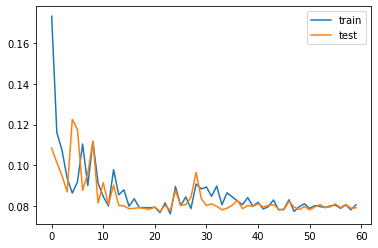

In [ ]:
plot_history(history)

### Predicting

Now we would like to use our network to predict on the test set. First we need to prepare it to fit as input for our networ. Remember our network takes as input a row with both the encoded dates and the sales at a given timestep. For the test data, we only have the sales information currently

Which input should we use as input to predict on our test data?

<details>
  <summary>View solution</summary>
Since we we cut the validation data at the end of the train data (so just before the test data), the last time step of the validation data is the one just before the first one of the test data so it's this one we want to use.

```python
input_test = validation_data_scaled[-1:]
```
</details>

In [ ]:
# YOUR CODE HERE
input_test = ...


In [ ]:
# This one has the correct format but once we predict on it, we want to use the 
# output as input
input_test

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1_store_1_sales,item_1_store_2_sales,item_1_store_3_sales,item_1_store_4_sales,item_1_store_5_sales,item_1_store_6_sales,item_1_store_7_sales,item_1_store_8_sales,item_1_store_9_sales,item_1_store_10_sales,item_2_store_1_sales,item_2_store_2_sales,item_2_store_3_sales,item_2_store_4_sales,item_2_store_5_sales,item_2_store_6_sales,item_2_store_7_sales,item_2_store_8_sales,item_2_store_9_sales,item_2_store_10_sales,item_3_store_1_sales,...,item_47_store_1_sales,item_47_store_2_sales,item_47_store_3_sales,item_47_store_4_sales,item_47_store_5_sales,item_47_store_6_sales,item_47_store_7_sales,item_47_store_8_sales,item_47_store_9_sales,item_47_store_10_sales,item_48_store_1_sales,item_48_store_2_sales,item_48_store_3_sales,item_48_store_4_sales,item_48_store_5_sales,item_48_store_6_sales,item_48_store_7_sales,item_48_store_8_sales,item_48_store_9_sales,item_48_store_10_sales,item_49_store_1_sales,item_49_store_2_sales,item_49_store_3_sales,item_49_store_4_sales,item_49_store_5_sales,item_49_store_6_sales,item_49_store_7_sales,item_49_store_8_sales,item_49_store_9_sales,item_49_store_10_sales,item_50_store_1_sales,item_50_store_2_sales,item_50_store_3_sales,item_50_store_4_sales,item_50_store_5_sales,item_50_store_6_sales,item_50_store_7_sales,item_50_store_8_sales,item_50_store_9_sales,item_50_store_10_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.487179,0.480769,0.326087,0.38,0.567568,0.485714,0.384615,0.38,0.319149,0.469388,0.593407,0.469027,0.494949,0.45,0.564103,0.552239,0.446154,0.628319,0.431579,0.365591,0.33871,...,0.216216,0.339286,0.456522,0.428571,0.441176,0.472222,0.30303,0.296296,0.489796,0.363636,0.419753,0.425926,0.414141,0.351064,0.535211,0.295775,0.416667,0.44898,0.340909,0.4875,0.304348,0.507463,0.259259,0.403509,0.390244,0.410256,0.230769,0.483871,0.428571,0.580645,0.282609,0.354839,0.436975,0.557692,0.307692,0.375,0.471429,0.38843,0.390909,0.464


In [ ]:
out_1 = simple_model(input_test.values.reshape((1, seq_length, nb_features)))
print(out_1.shape)

(1, 500)


We just need to add the encoded dates to out_1 so we can input it again into the model. Let's write a function to simply do that, the function should take the date as input (as `datetime` format) and returned the 19-long vector of encoded dayofweek and month.

In [ ]:
from tqdm import tqdm 

days_to_predict = 90

def date_to_encoding(mydate):
  # YOUR CODE HERE

    

<details>
  <summary>View solution</summary>

```python
days_to_predict = 90

def date_to_encoding(mydate):
  encoding = np.zeros((19), dtype=int)
  encoding[mydate.dayofweek] = 1
  encoding[6 + mydate.month] = 1
  return encoding
  
```

</details>

In [ ]:
# Let's try it out 
test_date_range = pd.to_datetime(test.date.unique())
print(len(test_date_range))
date_1_encoded = date_to_encoding(test_date_range[0])
input_1 = np.concatenate((date_1_encoded, out_1[0]))
print(input_1.shape)
out_2 = simple_model(input_1.reshape((1, seq_length, nb_features)))
print(out_2.shape)

90
(519,)
(1, 500)


Now that we tested the logic to build our prediction on the entire 90 day sequences, let's write a function to do it !

In [ ]:
# Preparing input
from datetime import datetime

def predict_next(sequence_input, days_to_predict=90):
  predictions = np.zeros((days_to_predict, nb_out))
  current_input = input_test.values.reshape((1, seq_length, nb_features))
  date_range = pd.date_range(list(input_test.index)[-1], periods=days_to_predict).tolist()

  # Here we start from our sequence_input, predict, format prediction as input
  # for the next timestep prediction and predict with it.
  # We also want to store the predictions at each time step since the function 
  # should return the predictions over the entire date_range (don't forget to 
  # apply the inverse of the min-max scaler for this step !)
  for i, date in tqdm(enumerate(date_range)):
    # YOUR CODE HERE
    output = ...
    predictions[i] = ...
    current_input = ...

  return pd.DataFrame(predictions, index=date_range, columns=cols_to_scale)


<details>
  <summary>View solution</summary>

```python
# Preparing input
from datetime import datetime

def predict_next(sequence_input, days_to_predict=90):
  predictions = np.zeros((days_to_predict, nb_out))
  current_input = input_test.values.reshape((1, seq_length, nb_features))
  date_range = pd.date_range(list(input_test.index)[-1], periods=days_to_predict).tolist()

  # Here we start from our sequence_input, predict, format prediction as input
  # for the next timestep prediction and predict with it.
  # We also want to store the predictions at each time step since the function 
  # should return the predictions over the entire date_range
  for i, date in tqdm(enumerate(date_range)):
    output = simple_model.predict(current_input)
    predictions[i] = (scaler.inverse_transform(output)[0]).astype(int)
    current_input = np.concatenate((date_to_encoding(date), output[0])).reshape((1, seq_length, nb_features))

  return pd.DataFrame(predictions, index=date_range, columns=cols_to_scale)

```

</details>

In [ ]:
days_to_predict = 180
input_test = X_val[:1]
y_test = validation_data[1:1+days_to_predict]
predictions_df = predict_next(input_test, days_to_predict=days_to_predict)

180it [00:07, 22.87it/s]


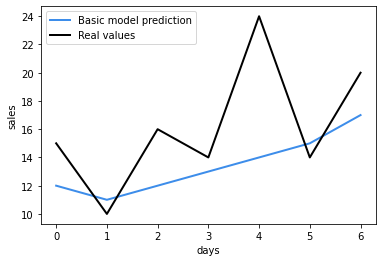

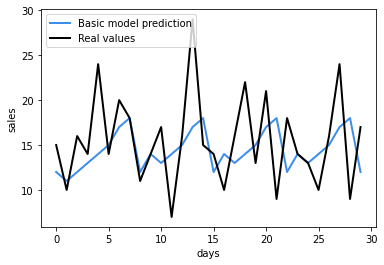

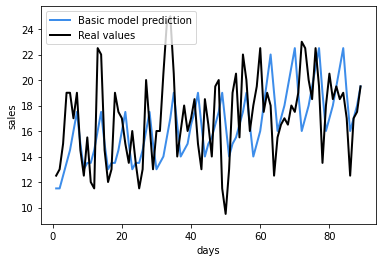

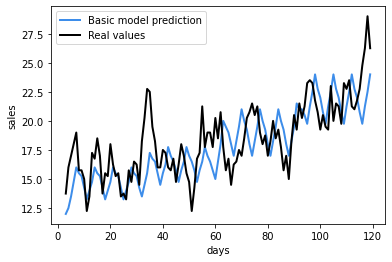

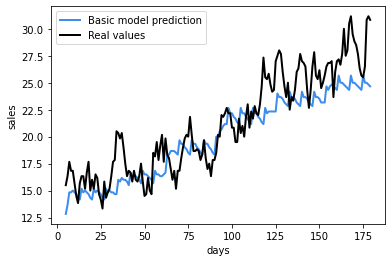

In [ ]:
# Visualising and compare to reality for a given store and item

color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

item = 1
store = 1
col_name = f'item_{item}_store_{store}_sales'

plot_lengths = [7, 30, 90, 120, 180]
rolling_mean_windows = [1, 1, 2, 4, 6]  # to make plots more readable

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(predictions_df[col_name].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    plt.plot(y_test[col_name].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.xlabel('days')
    plt.ylabel('sales')
    plt.show()